In [39]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [40]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers
from spectral import *
from patchify import patchify, unpatchify
import glob
from focal_loss import BinaryFocalLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
import random

In [41]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


##############################################################
'''
Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [42]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model


In [96]:
HEIGHT = 512
WIDTH = 512
CHANNELS = 9

In [97]:
X=[]
y=[]

for a in range(1,21):
  Xpath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field' + str(a) + '/cube_envi32.hdr'
  Ximg = spectral.open_image(Xpath)


  Field = Ximg.read_bands((37,51,52,53,77,90,91,92,127,130,131,132)) #9 bands
  #Field = Ximg.read_bands((52,53,91,92,131)) #5 bands
  #Field = Ximg.read_bands((37,52,53,91,92,127,131)) #5 bands
  #Field = Ximg.read_bands((37,77,127))
  
  ypath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field' + str(a) + '/Field' + str(a) + '-mask.tif'
  yimg = tf.keras.preprocessing.image.load_img(ypath, grayscale=True)
    

  Xpatches = patchify(Field,(HEIGHT,WIDTH,CHANNELS),step=HEIGHT)

  yimg = np.asarray(yimg)>0
  ypatches = patchify(yimg, (HEIGHT,WIDTH), step=HEIGHT)

  for m in range(0, Xpatches.shape[0]):
    for l in range(0, Xpatches.shape[1]):
      X.append(Xpatches[m,l,0])
      y.append(ypatches[m,l])


X = np.array(X)
y = np.array(y)

#X = (X/X.max())
#y = (y/y.max())

X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=42, test_size=0.20, shuffle=True)
y_train = y_train.astype(X_train.dtype)

/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [98]:
X_train[0].min()

-0.005375551

In [99]:
y_train.min()

0.0

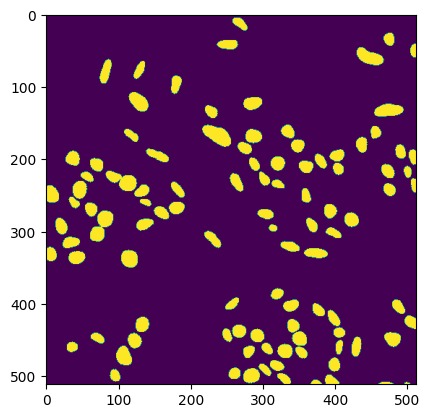

In [100]:
plt.imshow(y_train[0])

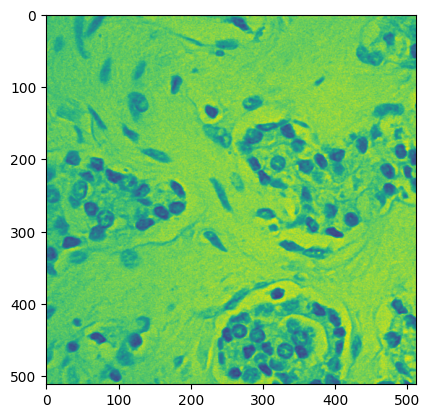

In [101]:
plt.imshow(X_train[0][:,:,-1])

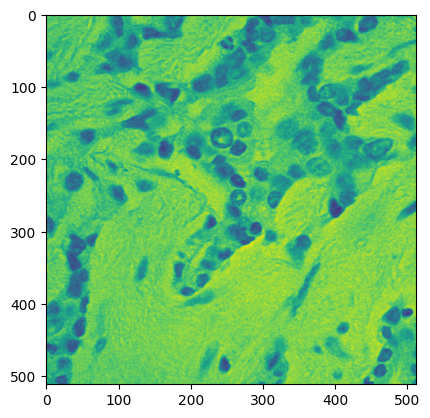

In [102]:
plt.imshow(X_test[0][:,:,-1])

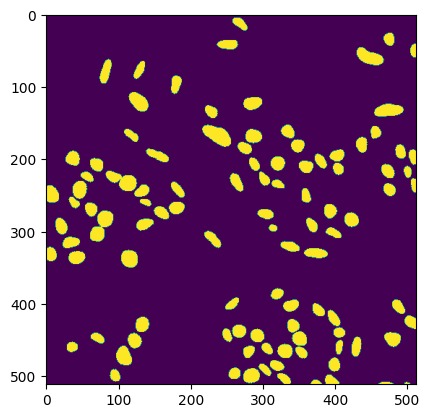

In [103]:
plt.imshow(y_train[0])

In [104]:
input_shape = (HEIGHT,WIDTH,CHANNELS)
model = Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True)

In [105]:
model.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 512, 512, 9)]        0         []                            
                                                                                                  
 conv2d_390 (Conv2D)         (None, 512, 512, 64)         5248      ['input_11[0][0]']            
                                                                                                  
 batch_normalization_270 (B  (None, 512, 512, 64)         256       ['conv2d_390[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_310 (Activation  (None, 512, 512, 64)         0         ['batch_normaliza

In [106]:
batch_size=1

In [107]:
import platform
from tensorflow.keras.callbacks import ModelCheckpoint

In [108]:
att_unet_model = Attention_UNet(input_shape)


att_unet_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='binary_crossentropy', metrics=['accuracy', jacard_coef])

filepath="/Users/anshugusain/tf-nuclei/Models/new_spectral-attention-bestVAL-20Images/Attention-" + str(CHANNELS) + "band-50epochs(512x512).h5"

print(att_unet_model.summary())
start2 = datetime.now() 
checkpoint = ModelCheckpoint(filepath, monitor='val_jacard_coef', verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]
att_unet_history = att_unet_model.fit(X_train, y_train, verbose=1,batch_size = batch_size,validation_data=(X_test, y_test ), shuffle=True, epochs=50, callbacks=callbacks_list)
stop2 = datetime.now()

#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 512, 512, 9)]        0         []                            
                                                                                                  
 conv2d_429 (Conv2D)         (None, 512, 512, 64)         5248      ['input_12[0][0]']            
                                                                                                  
 batch_normalization_297 (B  (None, 512, 512, 64)         256       ['conv2d_429[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_341 (Activation  (None, 512, 512, 64)         0         ['batch_normaliza

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x1x512xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x1x512xi1>'


16/16 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.8939 - jacard_coef: 0.1875
Epoch 1: val_jacard_coef improved from -inf to 0.14044, saving model to /Users/anshugusain/tf-nuclei/Models/new_spectral-attention-bestVAL-20Images/Attention-9band-50epochs(512x512).h5


/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 15s 685ms/step - loss: 0.5551 - accuracy: 0.8939 - jacard_coef: 0.1875 - val_loss: 13.0669 - val_accuracy: 0.1409 - val_jacard_coef: 0.1404
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.9292 - jacard_coef: 0.1982
Epoch 2: val_jacard_coef did not improve from 0.14044
16/16 [==============================] - 8s 526ms/step - loss: 0.5271 - accuracy: 0.9292 - jacard_coef: 0.1982 - val_loss: 12.9026 - val_accuracy: 0.1406 - val_jacard_coef: 0.1401
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.5171 - accuracy: 0.9344 - jacard_coef: 0.2003
Epoch 3: val_jacard_coef did not improve from 0.14044
16/16 [==============================] - 8s 517ms/step - loss: 0.5171 - accuracy: 0.9344 - jacard_coef: 0.2003 - val_loss: 0.5749 - val_accuracy: 0.8471 - val_jacard_coef: 0.0942
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.9364 - jacard_coef: 0.2032
Epoc

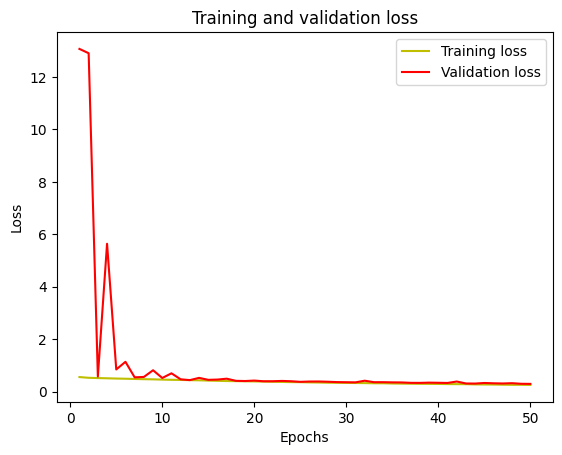

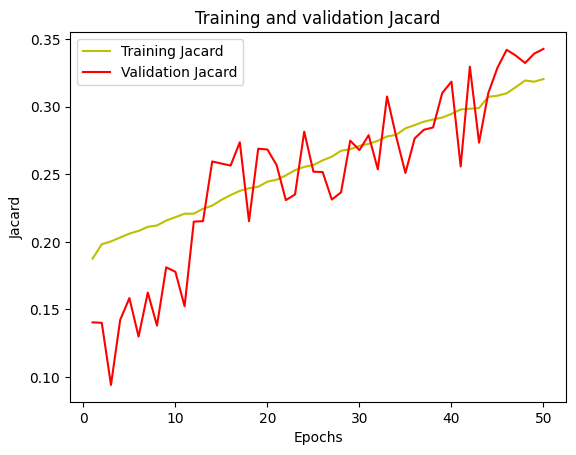

In [109]:
history = att_unet_history

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

In [110]:
model = tf.keras.models.load_model("/Users/anshugusain/tf-nuclei/Models/new_spectral-attention-bestVAL-20Images/Attention-" + str(CHANNELS) + "band-50epochs(512x512).h5", custom_objects={'jacard_coef_loss': jacard_coef_loss,'jacard_coef':jacard_coef})

In [111]:
def average_calc(X_examine, y_examine):
  IoUs = [len(X_examine)]
  total =0
  average =0

  for i in range(0,len(X_examine)):
    test_predict = model.predict(np.expand_dims(X_examine[i],0))
    test_predict = np.asarray(test_predict) 
    IoU = jaccard_score((test_predict).squeeze()>0.5, (y_examine[i]).squeeze()>0.5, average='micro')
    total =IoU + total
  average = total / len(X_examine)
  
  return average

def average_Fscore(X_examine, y_examine):
  IoUs = [len(X_examine)]
  total =0
  average =0

  for i in range(0,len(X_examine)):
    test_predict = model.predict(np.expand_dims(X_examine[i],0))
    test_predict = np.asarray(test_predict) 
    IoU = f1_score((test_predict>0.99).squeeze(), (y_examine[i]).squeeze(), average='micro')
    total =IoU + total
  average = total / len(X_examine)
  
  return average

In [112]:
average_calc(X_test, y_test)

1/1 [==============================] - 0s 143ms/step


0.7020454203835398

In [50]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [51]:
image_num = int(random.random()*len(X_test))
test_predict = model.predict(np.expand_dims(X_test[image_num],0))
test_predict = np.asarray(test_predict)

1/1 [==============================] - 0s 170ms/step


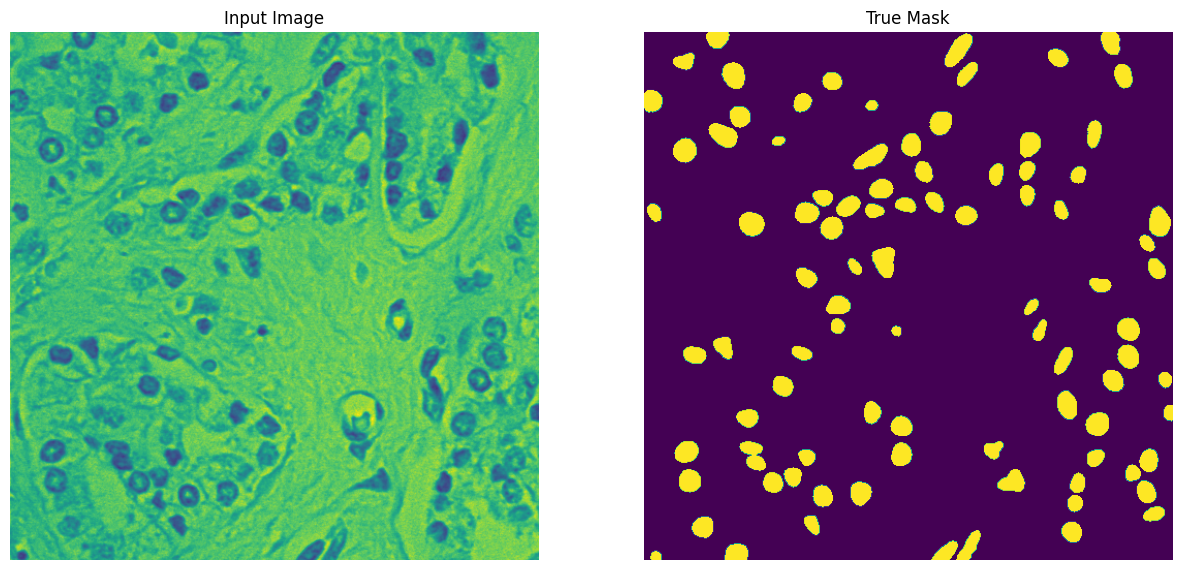

In [53]:
display((X_test[image_num][:,:,-2],y_test[image_num]))

In [54]:
(test_predict*1/test_predict.max()).squeeze().min()

0.034864314

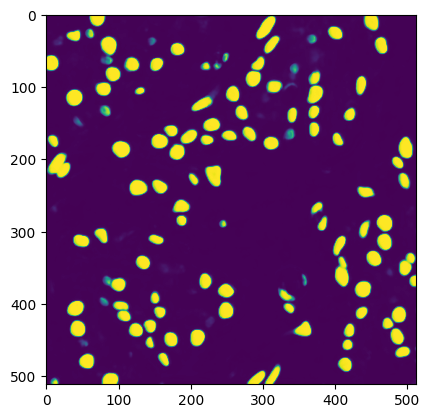

In [55]:
plt.imshow((test_predict*1/test_predict.max()).squeeze())